In [1]:
from eoxhub import check_compatibility
check_compatibility("user-2022.10-14", dependencies=[])

# Crop-classification using Sentinel-2 time-series

This notebook implements a crop classification algorithm for Sentinel-2 time-series based on deep learning. The input time-series are derived from the signals computed by the Eurocrops BYOA. The method here implemented is described in more detail in the [crop-classification marker blog-post](https://medium.com/sentinel-hub/area-monitoring-crop-type-marker-1e70f672bf44).

For more examples on how to create markers for monitoring agricultural activity using Sentinel-2 signals, consult [this blog series](https://medium.com/sentinel-hub/area-monitoring-concept-effc2c262583).

This notebook will use a sample of pre-downloaded signals, and can be run on a CPU-based instance or laptop.

**Table of Contents**:

 0. [Constants](#constants)
 1. [Retrieve signals and labels](#retrieve-signals)
 2. [AI-ready dataset](#dataset)
 3. [Model training](#model-training)
 4. [Model evaluation](#model-evaluation)

In [2]:
import os
import sys

!{sys.executable} -m pip install torch torchvision
os.environ['EDC_PATH'] + "/notebooks/contributions/eurocrops-model"
sys.path.append(os.path.join(os.environ['EDC_PATH'] + "/notebooks/contributions/eurocrops-model"))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/776.4 MB ? eta -:--:--

     ╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/776.4 MB 192.4 MB/s eta 0:00:04

     ━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.7/776.4 MB 228.1 MB/s eta 0:00:04

     ━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/776.4 MB 198.3 MB/s eta 0:00:04

     ━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/776.4 MB 182.8 MB/s eta 0:00:05

     ━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/776.4 MB 180.7 MB/s eta 0:00:05

     ━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/776.4 MB 178.5 MB/s eta 0:00:05

     ━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/776.4 MB 191.0 MB/s eta 0:00:04

     ━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/776.4 MB 203.1 MB/s eta 0:00:04

     ━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/776.4 MB 215.4 MB/s eta 0:00:04

     ━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/776.4 MB 202.4 MB/s eta 0:00:04

     ━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/776.4 MB 204.6 MB/s eta 0:00:04

     ━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/776.4 MB 206.5 MB/s eta 0:00:04

     ━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.3/776.4 MB 201.2 MB/s eta 0:00:04

     ━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.7/776.4 MB 227.2 MB/s eta 0:00:03

     ━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.1/776.4 MB 217.4 MB/s eta 0:00:03

     ━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/776.4 MB 229.2 MB/s eta 0:00:03

     ━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/776.4 MB 227.5 MB/s eta 0:00:03

     ━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/776.4 MB 228.0 MB/s eta 0:00:03

     ━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.7/776.4 MB 214.6 MB/s eta 0:00:03

     ━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.8/776.4 MB 204.7 MB/s eta 0:00:03

     ━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.5/776.4 MB 189.3 MB/s eta 0:00:03

     ━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.7/776.4 MB 191.3 MB/s eta 0:00:03

     ━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━ 233.3/776.4 MB 201.6 MB/s eta 0:00:03

     ━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/776.4 MB 215.4 MB/s eta 0:00:03

     ━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━ 252.1/776.4 MB 158.2 MB/s eta 0:00:04

     ━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/776.4 MB 183.3 MB/s eta 0:00:03

     ━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━ 270.3/776.4 MB 168.5 MB/s eta 0:00:04

     ━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━ 276.6/776.4 MB 181.3 MB/s eta 0:00:03

     ━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━ 288.3/776.4 MB 164.9 MB/s eta 0:00:03

     ━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━ 293.6/776.4 MB 164.1 MB/s eta 0:00:03

     ━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━ 301.4/776.4 MB 195.9 MB/s eta 0:00:03

     ━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 315.1/776.4 MB 202.3 MB/s eta 0:00:03

     ━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 321.5/776.4 MB 172.4 MB/s eta 0:00:03

     ━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━ 333.4/776.4 MB 166.1 MB/s eta 0:00:03

     ━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━ 339.7/776.4 MB 164.2 MB/s eta 0:00:03

     ━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━ 346.2/776.4 MB 183.2 MB/s eta 0:00:03

     ━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━ 358.1/776.4 MB 161.5 MB/s eta 0:00:03

     ━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━ 365.4/776.4 MB 199.8 MB/s eta 0:00:03

     ━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━ 378.1/776.4 MB 185.1 MB/s eta 0:00:03

     ━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━ 383.9/776.4 MB 181.1 MB/s eta 0:00:03

     ━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━ 396.9/776.4 MB 199.1 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━ 401.6/776.4 MB 167.8 MB/s eta 0:00:03

     ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━ 407.9/776.4 MB 157.1 MB/s eta 0:00:03

     ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━ 420.3/776.4 MB 178.9 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━ 426.8/776.4 MB 193.7 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━ 441.3/776.4 MB 198.3 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━ 448.7/776.4 MB 201.0 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━ 456.5/776.4 MB 226.1 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━ 469.8/776.4 MB 190.4 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━ 474.9/776.4 MB 170.5 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━ 487.8/776.4 MB 199.2 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━ 493.8/776.4 MB 182.0 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━ 508.3/776.4 MB 204.9 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━ 512.8/776.4 MB 164.0 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━ 527.2/776.4 MB 204.5 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━ 533.3/776.4 MB 177.0 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━ 539.7/776.4 MB 181.9 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━ 551.4/776.4 MB 152.4 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━ 558.8/776.4 MB 205.2 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━ 573.1/776.4 MB 218.5 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━ 580.7/776.4 MB 218.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━ 584.6/776.4 MB 160.5 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━ 599.5/776.4 MB 219.7 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━ 604.7/776.4 MB 167.8 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━ 617.7/776.4 MB 178.5 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━ 625.1/776.4 MB 184.2 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━ 636.8/776.4 MB 165.4 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━ 643.1/776.4 MB 166.2 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━ 649.3/776.4 MB 179.5 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━ 660.1/776.4 MB 153.4 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━ 666.0/776.4 MB 180.0 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━ 678.6/776.4 MB 197.5 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━ 685.1/776.4 MB 186.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━ 700.0/776.4 MB 205.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━ 705.6/776.4 MB 173.4 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━ 711.9/776.4 MB 167.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 725.7/776.4 MB 186.2 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 733.7/776.4 MB 226.7 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━ 747.6/776.4 MB 196.4 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━ 755.3/776.4 MB 219.7 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 771.0/776.4 MB 218.0 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 232.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.4/776.4 MB 378.7 kB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/19.1 MB ? eta -:--:--

     ━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/19.1 MB 150.0 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━ 16.5/19.1 MB 159.6 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 19.1/19.1 MB 168.2 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 19.1/19.1 MB 168.2 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 19.1/19.1 MB 168.2 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 19.1/19.1 MB 168.2 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 19.1/19.1 MB 168.2 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 19.1/19.1 MB 168.2 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 19.1/19.1 MB 168.2 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 19.1/19.1 MB 168.2 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 19.1/19.1 MB 168.2 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 19.1/19.1 MB 168.2 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 19.1/19.1 MB 168.2 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 19.1/19.1 MB 168.2 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 19.1/19.1 MB 168.2 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 19.1/19.1 MB 168.2 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 19.1/19.1 MB 168.2 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 12.0 MB/s eta 0:00:00


In [3]:
import json
import logging
import sys
import zipfile

import geopandas as gpd
import numpy as np
import pandas as pd
import subprocess
from lstm import LSTM
from polygon import PolyDataset
from transforms import get_sample_n_timestamps
from utils import test, train
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from torch.utils.data import DataLoader

from sentinelhub import parse_time

## 0. Constants <a name=constants></a>

This section initialises paths, constants and utility functions used in the notebook.

In [4]:
# path to local folders, change as desired
INPUT_FOLDER = "./input"
RESULTS_FOLDER = "./output"

# name of files and folders of downloaded signals, do not change
DATAFILE = "ml-example-data.zip"
DOWNLOAD_URL = f"https://sinergise0-my.sharepoint.com/:u:/g/personal/nejc_vesel_sinergise_com/ETMx7NG-JHpBntNMJfnsCOMBVuEegDjYq8WtTmJYl8tZ-A?e=Ck5opE&download=1"
EUROCROPS_GPKG = "input_geometries.gpkg"
SIGNALS_FOLDER = "ml-example-signals"


# utility function to read json payload into a dataframe
def stats_to_df(stats_data):
    """Transform Statistical API response into a pandas.DataFrame"""
    df_data = []

    for single_data in stats_data["data"]:
        df_entry = {}
        is_valid_entry = True

        df_entry["interval_from"] = parse_time(single_data["interval"]["from"]).date()
        df_entry["interval_to"] = parse_time(single_data["interval"]["to"]).date()

        for output_name, output_data in single_data["outputs"].items():
            for band_name, band_values in output_data["bands"].items():
                band_stats = band_values["stats"]
                if band_stats["sampleCount"] == band_stats["noDataCount"]:
                    is_valid_entry = False
                    break

                for stat_name, value in band_stats.items():
                    col_name = f"{output_name}_{band_name}_{stat_name}"
                    if stat_name == "percentiles":
                        for perc, perc_val in value.items():
                            perc_col_name = f"{col_name}_{perc}"
                            df_entry[perc_col_name] = perc_val
                    else:
                        df_entry[col_name] = value

        if is_valid_entry:
            df_data.append(df_entry)

    return pd.DataFrame(df_data)


# utility function to log training progress
def define_logger(logger_name) -> logging.Logger:
    logger = logging.getLogger(logger_name)
    logger.setLevel(logging.INFO)
    formatter = logging.Formatter("[%(asctime)s] {%(filename)s:%(lineno)d} %(levelname)s - %(message)s")

    stdout_handler = logging.StreamHandler(sys.stdout)
    stdout_handler.setFormatter(formatter)
    logger.addHandler(stdout_handler)
    return logger

## 1. Retrieve signals and labels <a name=retrieve-signals></a>

In this Section, signals are read from JSON files, while the labels used during model training are extracted from the Eurocrops dataset. For this notebook, sample files are provided and downloaded locally in the following cells. 

In [5]:
if not os.path.exists(INPUT_FOLDER):
    os.mkdir(INPUT_FOLDER)

In [6]:
wget_str = f"wget {DOWNLOAD_URL} -O {os.path.join(INPUT_FOLDER, DATAFILE)}"
subprocess.call(wget_str.split(" "))

--2022-10-26 01:38:57--  https://sinergise0-my.sharepoint.com/:u:/g/personal/nejc_vesel_sinergise_com/ETMx7NG-JHpBntNMJfnsCOMBVuEegDjYq8WtTmJYl8tZ-A?e=Ck5opE&download=1
Resolving sinergise0-my.sharepoint.com (sinergise0-my.sharepoint.com)... 13.107.136.9, 13.107.138.9
Connecting to sinergise0-my.sharepoint.com (sinergise0-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 

302 Found
Location: /personal/nejc_vesel_sinergise_com/Documents/ml-example-data.zip?ga=1 [following]
--2022-10-26 01:38:57--  https://sinergise0-my.sharepoint.com/personal/nejc_vesel_sinergise_com/Documents/ml-example-data.zip?ga=1
Reusing existing connection to sinergise0-my.sharepoint.com:443.
HTTP request sent, awaiting response... 

200 OK
Length: 88085785 (84M) [application/x-zip-compressed]
Saving to: ‘./input/ml-example-data.zip’

     0K .......... .......... .......... .......... ..........  0% 6.85M 12s
    50K .......... .......... .......... .......... ..........  0% 6.79M 12s
   100K .......... .......... .......... .......... ..........  0% 6.55M 12s
   150K .......... .......... .......... .......... ..........  0%  325M 9s
   200K .......... .......... .......... .......... ..........  0% 7.45M 10s
   250K .......... .......... .......... .......... ..........  0% 74.6M 8s
   300K .......... .......... .......... .......... ..........  0%  108M 7s
   350K .......... .......... .......... .......... ..........  0%  140M 6s
   400K .......... .......... .......... .......... ..........  0% 8.56M 7s
   450K .......... .......... .......... .......... ..........  0%  204M 6s
   500K .......... .......... .......... .......... ..........  0%  347M 6s
   550K .......... .......... .......... .......... .....

.... .......... .......... .......... .......... 14%  100M 1s
 12100K .......... .......... .......... .......... .......... 14%  121M 1s
 12150K .......... .......... .......... .......... .......... 14%  203M 1s
 12200K .......... .......... .......... .......... .......... 14%  235M 1s
 12250K .......... .......... .......... .......... .......... 14%  298M 1s
 12300K .......... .......... .......... .......... .......... 14%  307M 1s
 12350K .......... .......... .......... .......... .......... 14%  335M 1s
 12400K .......... .......... .......... .......... .......... 14%  237M 1s
 12450K .......... .......... .......... .......... .......... 14%  273M 1s
 12500K .......... .......... .......... .......... .......... 14%  341M 1s
 12550K .......... .......... .......... .......... .......... 14%  326M 1s
 12600K .......... .......... .......... .......... .......... 14%  256M 1s
 12650K .......... .......... .......... .......... .......... 14%  346M 1s
 12700K .......... .......


 24600K .......... .......... .......... .......... .......... 28% 52.9M 1s
 24650K .......... .......... .......... .......... .......... 28%  104M 1s
 24700K .......... .......... .......... .......... .......... 28%  363M 1s
 24750K .......... .......... .......... .......... .......... 28%  353M 1s
 24800K .......... .......... .......... .......... .......... 28% 47.4M 1s
 24850K .......... .......... .......... .......... .......... 28%  349M 1s
 24900K .......... .......... .......... .......... .......... 29%  358M 1s
 24950K .......... .......... .......... .......... .......... 29%  346M 1s
 25000K .......... .......... .......... .......... .......... 29% 95.4M 1s
 25050K .......... .......... .......... .......... .......... 29%  258M 1s
 25100K .......... .......... .......... .......... .......... 29%  284M 1s
 25150K .......... .......... .......... .......... .......... 29%  309M 1s
 25200K .......... .......... .......... .......... .......... 29%  303M 1s
 25250K ...

...... .......... .......... .......... 56%  182K 1s
 48300K .......... .......... .......... .......... .......... 56%  149M 1s
 48350K .......... .......... .......... .......... .......... 56%  161M 1s
 48400K .......... .......... .......... .......... .......... 56%  147M 1s
 48450K .......... .......... .......... .......... .......... 56%  119M 1s
 48500K .......... .......... .......... .......... .......... 56%  191M 1s
 48550K .......... .......... .......... .......... .......... 56%  162M 1s
 48600K .......... .......... .......... .......... .......... 56% 75.8M 1s
 48650K .......... .......... .......... .......... .......... 56%  122M 1s
 48700K .......... .......... .......... .......... .......... 56%  211M 1s
 48750K .......... .......... .......... .......... .......... 56%  228M 1s
 48800K .......... .......... .......... .......... .......... 56%  171M 1s
 48850K .......... .......... .......... .......... .......... 56%  144M 1s
 48900K .......... .......... .....

........ .......... .......... .......... .......... 85%  611K 0s
 73400K .......... .......... .......... .......... .......... 85%  261M 0s
 73450K .......... .......... .......... .......... .......... 85%  337M 0s
 73500K .......... .......... .......... .......... .......... 85%  349M 0s
 73550K .......... .......... .......... .......... .......... 85%  271M 0s
 73600K .......... .......... .......... .......... .......... 85%  256M 0s
 73650K .......... .......... .......... .......... .......... 85%  285M 0s
 73700K .......... .......... .......... .......... .......... 85%  280M 0s
 73750K .......... .......... .......... .......... .......... 85%  259M 0s
 73800K .......... .......... .......... .......... .......... 85%  210M 0s
 73850K .......... .......... .......... .......... .......... 85%  230M 0s
 73900K .......... .......... .......... .......... .......... 85%  244M 0s
 73950K .......... .......... .......... .......... .......... 86%  339M 0s
 74000K .......... ...

0

In [7]:
# unzip files
with zipfile.ZipFile(os.path.join(INPUT_FOLDER, DATAFILE), "r") as zip_ref:
    zip_ref.extractall(INPUT_FOLDER)

In [8]:
!ls {INPUT_FOLDER}

input_geometries.gpkg  ml-example-data.zip  ml-example-signals


Read signals from JSON files as returned by Statistical API and create a dataframe.

In [9]:
dfs = []
for result_json in os.listdir(os.path.join(INPUT_FOLDER, "ml-example-signals")):
    with open(os.path.join(INPUT_FOLDER, "ml-example-signals", result_json)) as f:
        result = json.load(f)

    result_df = stats_to_df(result["response"])
    result_df["identifier"] = int(result["identifier"])
    dfs.append(result_df)

signals = pd.concat(dfs)

Check size of dataset and one time observation.

In [10]:
len(signals)

157500

In [11]:
signals.iloc[0]

interval_from            2021-01-05
interval_to              2021-01-06
clm_B0_min                      1.0
clm_B0_max                      1.0
clm_B0_mean                     1.0
                            ...    
bands_B12_mean             0.028348
bands_B12_stDev            0.003333
bands_B12_sampleCount            96
bands_B12_noDataCount            65
identifier                   331393
Name: 0, Length: 93, dtype: object

Read labels from provided geopackage file. These labels can be directly retrieved from GeoDB.

In [12]:
eurocrops_gdf = gpd.read_file(os.path.join(INPUT_FOLDER, EUROCROPS_GPKG))

Merge signals and crop labels into a single dataframe, by looking at the identifier of the field of interest (FOI).

In [13]:
eurocrops_signals = pd.merge(eurocrops_gdf, signals, on="identifier")

In [14]:
eurocrops_signals.iloc[0]

identifier                                         296351
created_at               2022-07-06T21:34:12.027081+00:00
modified_at                                          None
_fid                                                  NaN
fs_kennung                                            NaN
                                       ...               
bands_B12_max                                      0.3369
bands_B12_mean                                    0.28427
bands_B12_stDev                                   0.03697
bands_B12_sampleCount                                 112
bands_B12_noDataCount                                  72
Name: 0, Length: 121, dtype: object

## 2. AI-ready dataset <a name=dataset></a>

This Section adds some features to be added to the raw bands which will be used by the model.

In [15]:
# add column for cloud probability
eurocrops_signals["CLP"] = eurocrops_signals["clp_B0_mean"] / 255
# compute NDVI
eurocrops_signals["NDVI"] = (eurocrops_signals["bands_B7_mean"] - eurocrops_signals["bands_B3_mean"]) / (
    eurocrops_signals["bands_B7_mean"] + eurocrops_signals["bands_B3_mean"]
)
# compute day-of-year from timestamp
eurocrops_signals["DOY"] = eurocrops_signals.interval_from.apply(lambda x: x.timetuple().tm_yday)

In [16]:
# get name of columns to be used as features, i.e. mean values of raw bands
feature_cols = [x for x in eurocrops_signals.columns if x.startswith("bands_") and x.endswith("_mean")]
# name of utility features
doy_feature = "DOY"
crop_type_feature = "ec_hcat_c"
crop_name_feature = "ec_hcat_n"
label_feature = "label"
identifier_feature = "identifier"

Map all the possible crop-types to specific groups assigned in Eurocrops.

In [17]:
crop_id_to_label_mapping = {val: idx for idx, val in enumerate(eurocrops_signals[crop_type_feature].unique())}

In [18]:
crop_id_to_name_mapping = {
    crop_id: crop_name
    for crop_id, crop_name in eurocrops_signals[[crop_type_feature, crop_name_feature]].drop_duplicates().values
}

In [19]:
eurocrops_signals[label_feature] = eurocrops_signals[crop_type_feature].map(crop_id_to_label_mapping)

Split the signals into a training and validation set. This datasets are demonstrative only, as in reality, a larger dataset would be required, and more robust validation strategies required to robustly estimate the performance of the model.

In [20]:
train_ids, val_ids = train_test_split(
    eurocrops_signals[identifier_feature].unique(), train_size=0.6, test_size=0.4, random_state=42
)

In [21]:
train_df = eurocrops_signals[eurocrops_signals[identifier_feature].isin(train_ids)]
val_df = eurocrops_signals[eurocrops_signals[identifier_feature].isin(val_ids)]

Create the training and validation datasets to be used for model training and validation.

In [22]:
train_poly_dataset = PolyDataset(
    train_df,
    feature_cols=feature_cols,
    label_col=label_feature,
    poly_id_col=identifier_feature,
    doys_col=doy_feature,
    online_transform=get_sample_n_timestamps(40),
)

val_poly_dataset = PolyDataset(
    val_df,
    feature_cols=feature_cols,
    label_col=label_feature,
    poly_id_col=identifier_feature,
    doys_col=doy_feature,
    online_transform=get_sample_n_timestamps(40),
)

## 3. Model training <a name=model-training></a>

In this Section, a LSTM model is trained on the signals for estimation of crop-type. The parameters of the LSTM might need tuning to different use-cases.

In [23]:
BATCH_SIZE = 16
N_WORKERS = 4
SHUFFLE = True

The number of epochs is set to 5 to for this demonstration. For more accurate results, it is recommended that this is increased (i.e. to 20 or 30). 

In [24]:
N_EPOCHS = 5 

In [25]:
train_loader = DataLoader(dataset=train_poly_dataset, batch_size=BATCH_SIZE, num_workers=N_WORKERS, shuffle=SHUFFLE)

val_loader = DataLoader(dataset=val_poly_dataset, batch_size=BATCH_SIZE, num_workers=N_WORKERS, shuffle=False)

Initialise the model.

In [26]:
lstm = LSTM(
    input_dim=len(feature_cols),
    n_classes=eurocrops_signals[label_feature].nunique(),
    hidden_dims=128,
    num_rnn_layers=3,
    dropout=0.2,
    bidirectional=True,
    use_batchnorm=False,
    use_layernorm=True,
)

Initialise the optimiser.

In [27]:
optimizer = Adam(
    filter(lambda x: x.requires_grad, lstm.parameters()),
    betas=(0.9, 0.98),
    eps=1e-09,
    lr=0.001,
)

Initialise the logger.

In [28]:
logger = define_logger("Training")

Train the model !!

In [29]:
lstm = train(lstm, optimizer, train_loader, val_loader, N_EPOCHS, verbose=False, logger=logger)

[2022-10-26 01:41:00,341] {utils.py:87} INFO - Epoch 0: train loss 2.240 | val loss 1.913 | val acc = 0.461


[2022-10-26 01:42:01,324] {utils.py:87} INFO - Epoch 1: train loss 1.851 | val loss 1.750 | val acc = 0.519


[2022-10-26 01:42:59,048] {utils.py:87} INFO - Epoch 2: train loss 1.666 | val loss 1.662 | val acc = 0.556


[2022-10-26 01:43:55,145] {utils.py:87} INFO - Epoch 3: train loss 1.604 | val loss 1.639 | val acc = 0.546


[2022-10-26 01:44:52,348] {utils.py:87} INFO - Epoch 4: train loss 1.519 | val loss 1.542 | val acc = 0.588


## 4. Model evaluation <a name=model-evaluation></a>

This Section evaluates the performance of the trained model on the validation dataset. Perfomance is displayed as a confusion matrix, where estimated and reference crop-types are compared.

In [30]:
import numpy as np

In [31]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(20, 20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = np.nanmax(cm) / 1.5 if normalize else np.nanmax(cm) / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.2f}; misclass={:0.2f}'.format(accuracy, misclass))
    plt.show()


In [32]:
predictions, targets, polygon_ids, logprobabilities = test(lstm, val_loader)

In [33]:
cm = confusion_matrix(targets, predictions, labels=list(crop_id_to_label_mapping.values()))

/tmp/ipykernel_70/2388789195.py:57: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


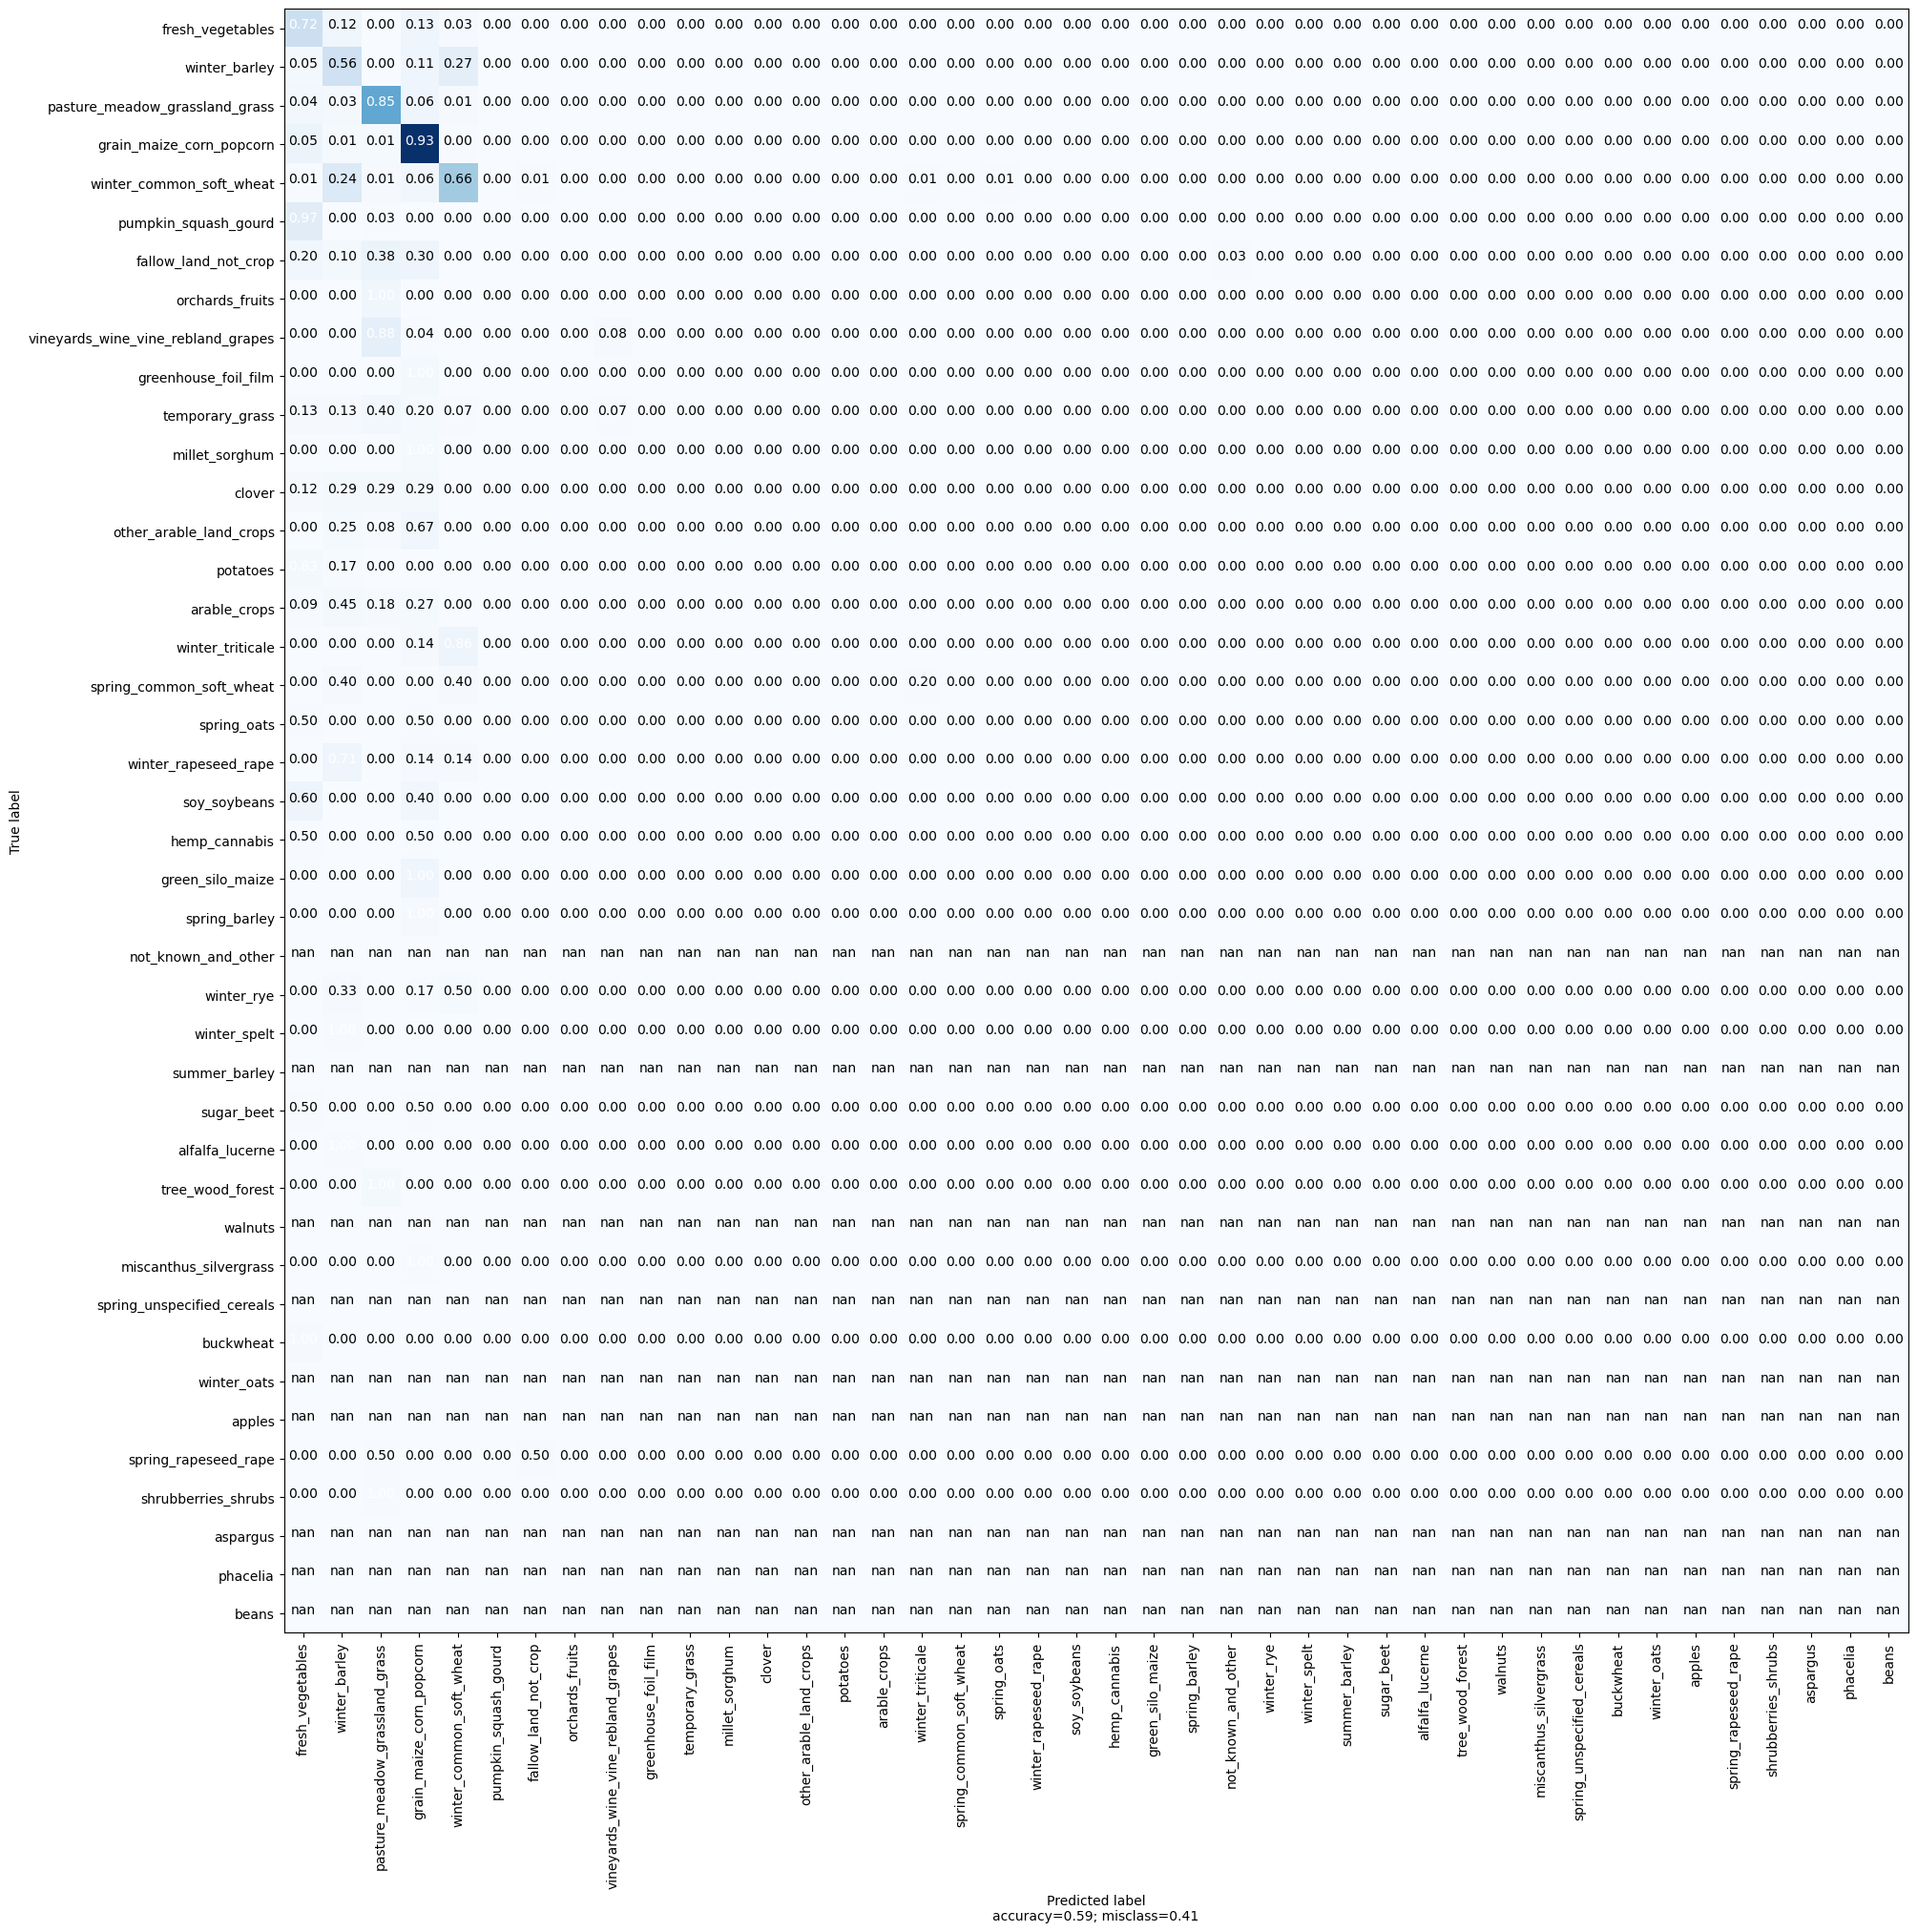

In [34]:
plot_confusion_matrix(cm, target_names=[crop_id_to_name_mapping[x] for x in crop_id_to_label_mapping.keys()])